In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
from dashboard_app._format_utils import format_price_short

# Define custom color palette
colors = ["#6C969D", "#97CC04", "#2D7DD2", "#EEB902", "#474647", "#F45D01", "#9B6B6C", "#556F44"]
# custom_cmap = LinearSegmentedColormap.from_list("custom", colors)

# Set global figure size and DPI
# Set figure size optimized for A4 (297mm x 210mm at 300dpi)
plt.rcParams['figure.figsize'] = (10, 7)  # Adjusted for better A4 fit
plt.rcParams['figure.dpi'] = 300

# Configure fonts
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 11  # Base font size
plt.rcParams['font.weight'] = 'normal'

# grid lines subtle thin
plt.rcParams['grid.color'] = '#d9d9d9'
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.linewidth'] = 0.5

# spines light gray thin
plt.rcParams['axes.edgecolor'] = '#d9d9d9'
plt.rcParams['axes.linewidth'] = 0.5


# Function to format event datetime
def format_event_datetime(dt, include_time=True):
	"""Format datetime to event-relative format (Day 1, Day 2, Day 3)"""
	if isinstance(dt, str):
		dt = pd.to_datetime(dt)

	event_days = {
		pd.Timestamp('2024-07-04').date(): 'Day 1',
		pd.Timestamp('2024-07-05').date(): 'Day 2',
		pd.Timestamp('2024-07-06').date(): 'Day 3'
	}

	date_only = dt.date()
	day_label = event_days.get(date_only, 'Day 1')  # Default to Day 1 instead of Unknown Day

	if include_time:
		return f"{day_label} {dt.strftime('%H:00')}"  # Changed to show only hour
	return day_label


# Function to load data from CSV or DataFrame
def load_data(data_source):
	if isinstance(data_source, str):
		# Load data from CSV file
		data = pd.read_csv(f"./thesis/results/{data_source}")
	else:
		# Assume data_source is a DataFrame
		data = data_source
	return data


# Function to create subplots with consistent formatting
def create_subplots(nrows=1, ncols=1, figsize=(10, 6), sharex=False, sharey=False):
	fig, axes = plt.subplots(nrows, ncols, figsize=figsize, sharex=sharex, sharey=sharey)

	if nrows * ncols > 1:
		for ax in axes.flat:
			ax.tick_params(axis='both', which='major', labelsize=10)
			ax.tick_params(axis='both', which='minor', labelsize=8)
	else:
		axes.tick_params(axis='both', which='major', labelsize=10)
		axes.tick_params(axis='both', which='minor', labelsize=8)

	return fig, axes


# Function to format x-labels as event datetime
def format_xaxis_event_datetime(ax, include_time=True):
	ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: format_event_datetime(pd.to_datetime(x), include_time)))
	plt.xticks(rotation=45, ha='right')


# Function to add reference line to plot
def add_reference_line(ax, x=None, y=None, color='gray', linestyle='--', linewidth=1, label=None):
	if x is not None:
		ax.axvline(x, color=color, linestyle=linestyle, linewidth=linewidth, label=label)
	elif y is not None:
		ax.axhline(y, color=color, linestyle=linestyle, linewidth=linewidth, label=label)


# Function to save chart with consistent formatting
def save_chart(p, filename, dpi=300, bbox_inches='tight', pad_inches=0.1):
	p.savefig(f"./thesis/results/{filename}", dpi=dpi, bbox_inches=bbox_inches, pad_inches=pad_inches)

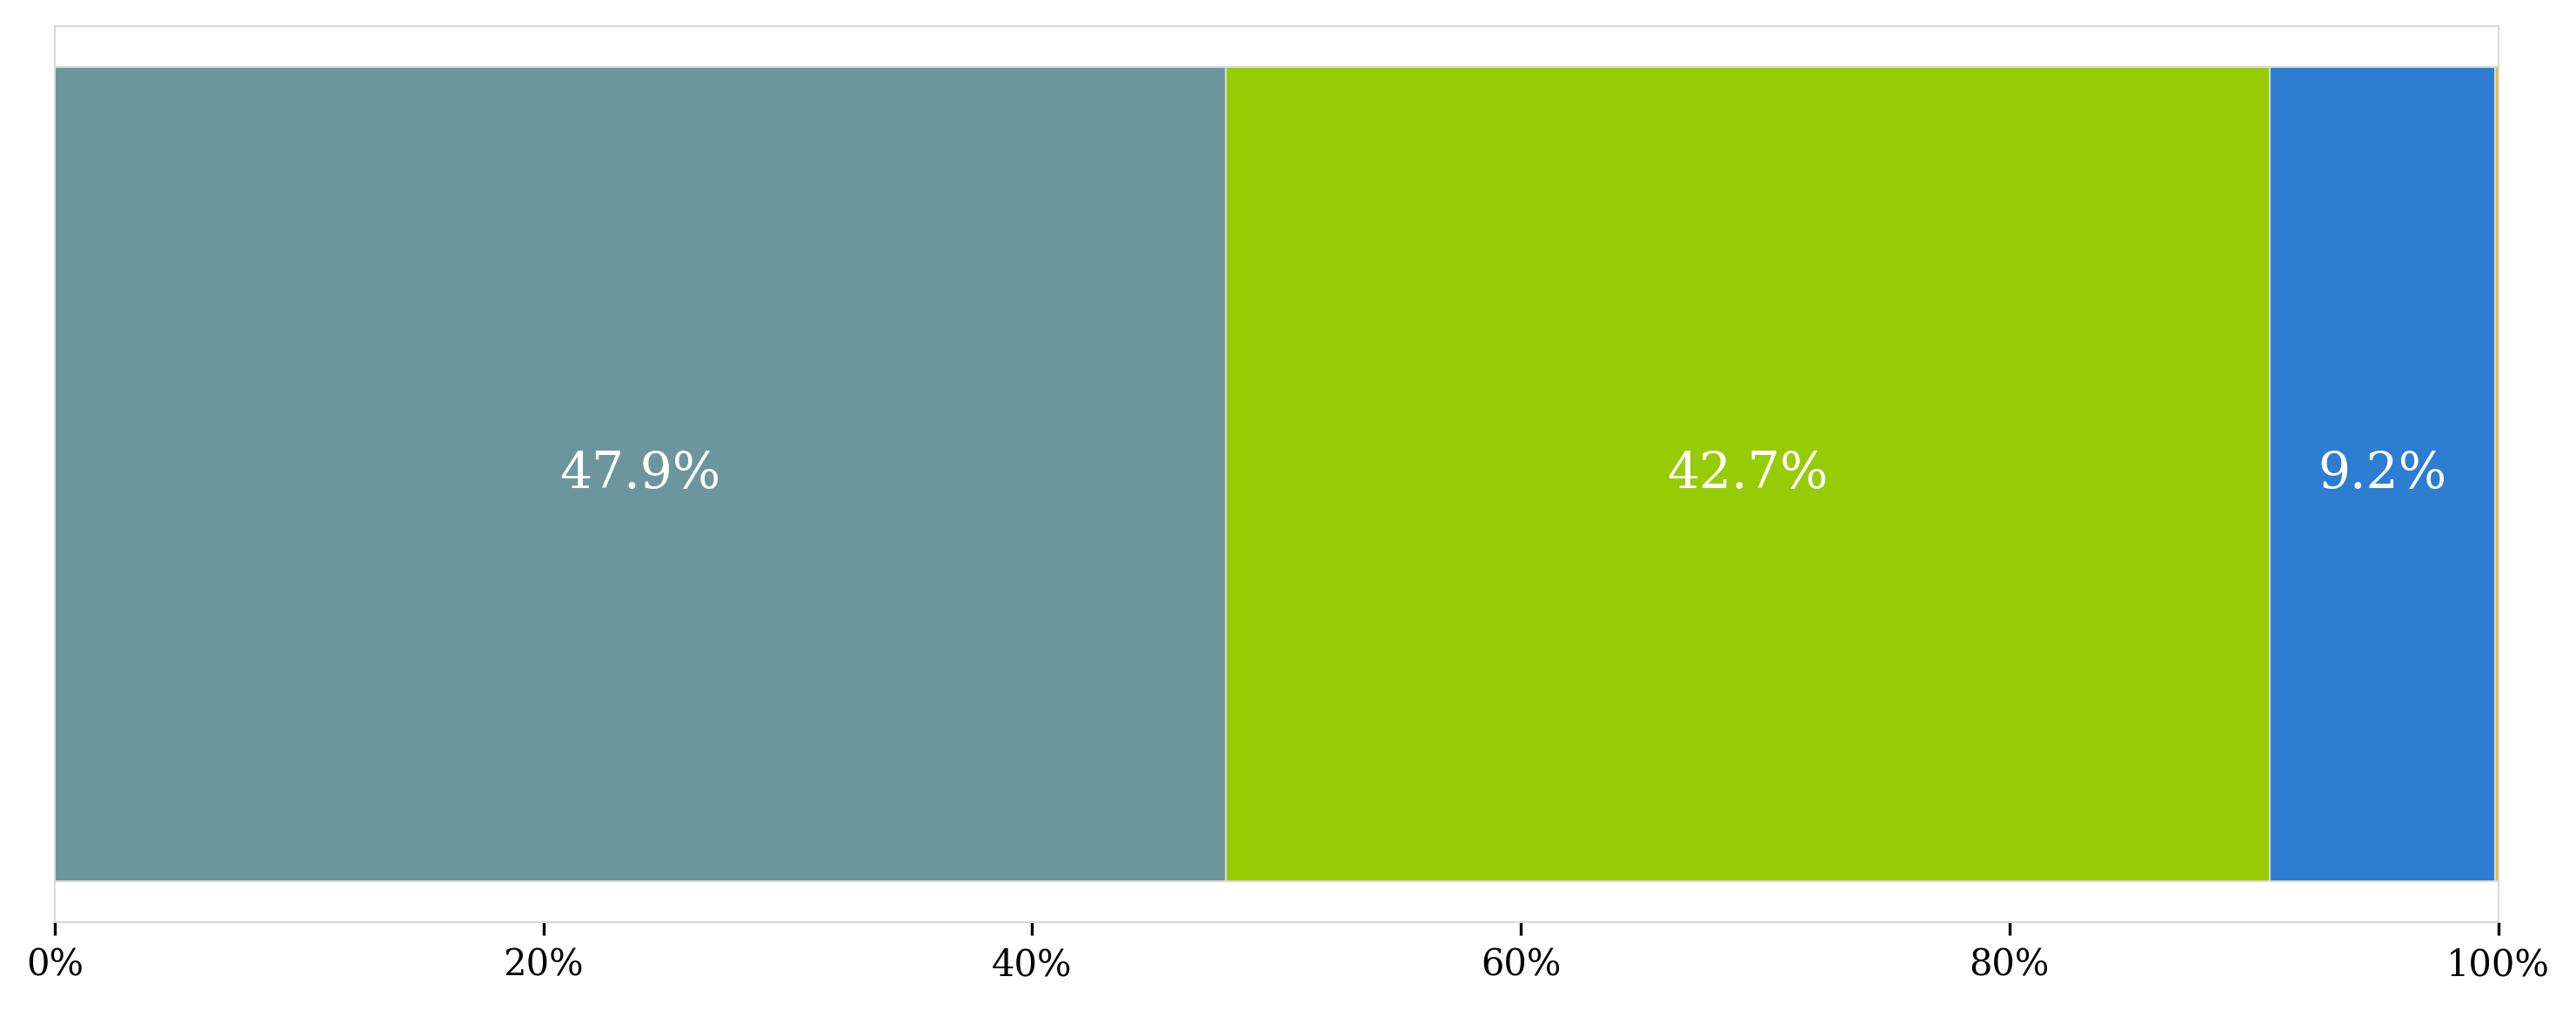

In [45]:
# Data from the pie chart
data = {
	"Payment Method": ["Card terminal", "Cash", "Online pre top-up", "VIP issued"],
	"Count": [8486, 7561, 1634, 23],
	"Total Value (CZK)": [7264503, 5782570, 1436400, 37500]
}

# Convert data to a DataFrame
df = pd.DataFrame(data)

# Calculate proportions for the 100% stacked bar chart
df["Proportion"] = df["Count"] / df["Count"].sum()

# Define a minimum proportion for visibility
min_proportion = 0.02  # Set minimum visual width (2%)
df["Visual Proportion"] = df["Proportion"].apply(lambda x: max(x, min_proportion))

# Prepare data for plotting
methods = df["Payment Method"]
proportions = df["Proportion"]
visual_proportions = df["Visual Proportion"]
total_values = df["Total Value (CZK)"]

# Create a subplot
fig, ax = create_subplots(figsize=(10, 4))  # Wider figure for a horizontal bar

# Plot the horizontal 100% stacked bar chart
left = 0
for i, (proportion, visual_proportion, method, value, color) in enumerate(
		zip(proportions, visual_proportions, methods, total_values, colors[:len(methods)])
):
	ax.barh(
		y=0,
		width=visual_proportion,
		left=left,
		color=color,
		edgecolor="#d9d9d9",
		linewidth=0.5,
		label=method
	)
	# Add proportion and value label inside or outside based on size
	label_text = f"{proportion * 100:.1f}%"
	if visual_proportion < 0.03:  # If the segment is small, place the label outside
		continue
	else:
		ax.text(
			left + visual_proportion / 2,
			0,
			label_text,
			ha='center',
			va='center',
			color='white',
			fontsize=14,
		)
	left += visual_proportion

# Customize the axes
ax.set_xlim(0, 1)
ax.set_yticks([])  # Remove y-ticks as it is a single bar
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{int(x * 100)}%"))
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=4, fontsize=10, frameon=False)

plt.tight_layout()
plt.show()

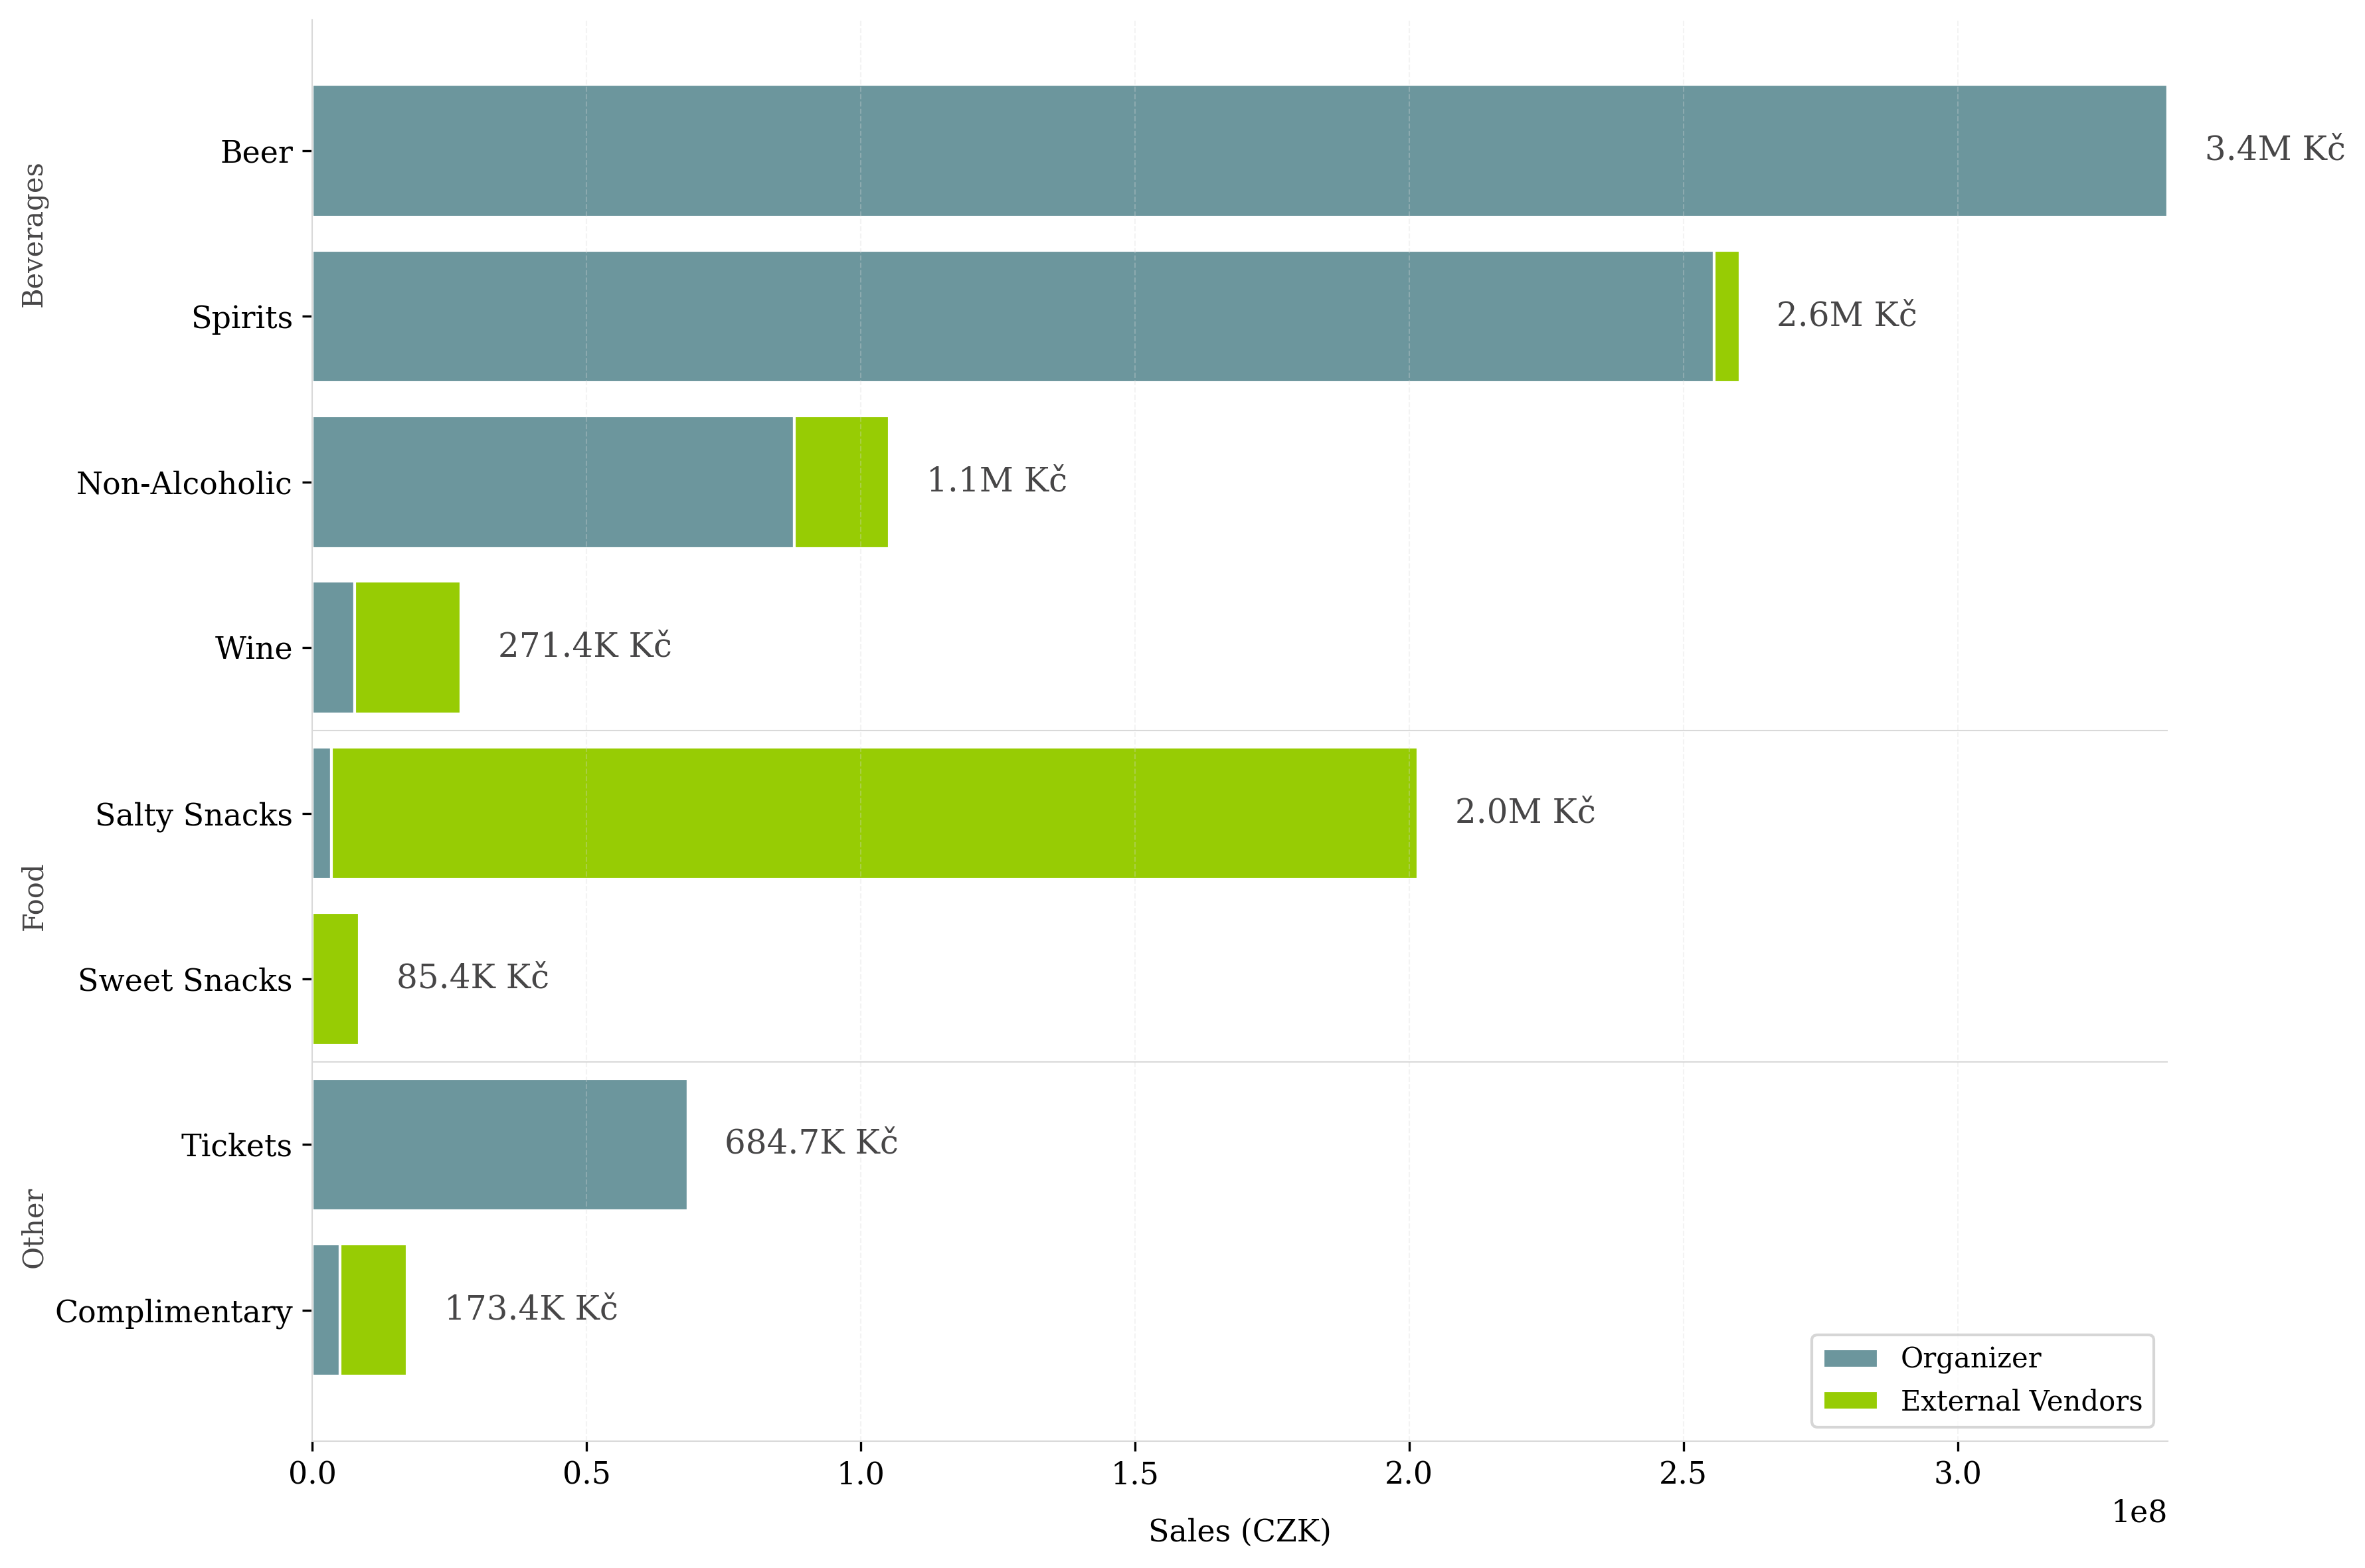

In [43]:
import matplotlib.pyplot as plt

data = load_data("rq4-organizer-vs-vendor-sales.csv")

# Define category order and grouping (reversed for bottom-to-top display)
category_order = [
	'complimentary', 'ticket',  # Other
	'sweet', 'salty',  # Food
	'wine', 'non_alcoholic', 'spirits', 'beer'  # Beverages
]

category_labels = {
	"beer": "Beer",
	"spirits": "Spirits",
	"non_alcoholic": "Non-Alcoholic",
	"wine": "Wine",
	"salty": "Salty Snacks",
	"sweet": "Sweet Snacks",
	"ticket": "Tickets",
	"complimentary": "Complimentary"
}

# Prepare data
organizer_values = data.loc[data['source'] == 'organizer', category_order].iloc[0]
external_values = data.loc[data['source'] == 'external', category_order].iloc[0]
total_values = organizer_values + external_values

# Create figure
fig, ax = plt.subplots(figsize=(12, 8))

# Plot bars
y_positions = range(len(category_order))
bars_organizer = ax.barh(
	y_positions, organizer_values,
	label="Organizer", color='#6C969D', edgecolor='white'
)
bars_external = ax.barh(
	y_positions, external_values, left=organizer_values,
	label="External Vendors", color='#97CC04', edgecolor='white'
)

# Add category labels
ax.set_yticks(y_positions)
ax.set_yticklabels([category_labels[cat] for cat in category_order], fontsize=11)

# Add value and percentage labels
for i, (org_val, ext_val) in enumerate(zip(organizer_values, external_values)):
	total = org_val + ext_val

	# Add total value
	ax.text(
		total + (max(total_values) * 0.02), i,
		format_price_short(total),
		va='center', ha='left', fontsize=12, color='#474647'
	)

# Add percentage for segments > 5%
# if org_val/total > 0.05:
# 	ax.text(org_val/2, i,
# 	        f'{org_val/total*100:.0f}%',
# 	        va='center', ha='center', color='white', fontsize=9)
# if ext_val/total > 0.05:
# 	ax.text(org_val + ext_val/2, i,
# 	        f'{ext_val/total*100:.0f}%',
# 	        va='center', ha='center', color='white', fontsize=9)

# Add gridlines
ax.grid(axis='x', linestyle='--', alpha=0.3, zorder=0)

# Add group separators
group_separators = [1.5, 3.5]  # Adjusted positions for reversed order
for sep in group_separators:
	ax.axhline(y=sep, color='#d9d9d9', linestyle='-', linewidth=0.5)

# Customize chart
ax.set_xlabel("Sales (CZK)", fontsize=11, labelpad=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(fontsize=10, loc="lower right")

# Add group labels with adjusted positions
ax.text(
	-max(total_values) * 0.15, 6.5, "Beverages", rotation=90,
	va='center', ha='center', fontsize=10, color='#474647'
)
ax.text(
	-max(total_values) * 0.15, 2.5, "Food", rotation=90,
	va='center', ha='center', fontsize=10, color='#474647'
)
ax.text(
	-max(total_values) * 0.15, 0.5, "Other", rotation=90,
	va='center', ha='center', fontsize=10, color='#474647'
)

plt.tight_layout()


